In [ ]:
import os

dataset_path = "DATASET"
# Note: I am using the specific folder names shown in your output (with spaces)
folders = ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']

total_images = 0

print(f"--- INSPECTING {dataset_path} ---")

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    
    if os.path.exists(folder_path):
        # Count files inside
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        count = len(files)
        total_images += count
        print(f"📁 {folder}: contains {count} images")
    else:
        print(f"❌ Folder '{folder}' does not exist.")

print("-" * 30)
if total_images == 0:
    print("⚠️ CONCLUSION: The folders are EMPTY. You need to move your images here.")
else:
    print(f"✅ CONCLUSION: Found {total_images} images! Your dataset is ALREADY labeled.")

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DATASET_PATH = "DATASET"

# Map current names (with spaces) to required names (snake_case)
RENAME_MAP = {
    "clear skin": "clear_skin",
    "dark spots": "dark_spots",
    "puffy eyes": "puffy_eyes",
    "wrinkles": "wrinkles" # This one is already correct, but good to include
}

print("--- 1. RENAMING FOLDERS (Standardizing) ---")
for old_name, new_name in RENAME_MAP.items():
    old_path = os.path.join(DATASET_PATH, old_name)
    new_path = os.path.join(DATASET_PATH, new_name)
    
    if os.path.exists(old_path) and old_path != new_path:
        os.rename(old_path, new_path)
        print(f"✅ Renamed: '{old_name}' -> '{new_name}'")
    elif os.path.exists(new_path):
        print(f"ℹ️ '{new_name}' already exists. Skipping rename.")
    else:
        print(f"⚠️ Could not find folder: '{old_name}'")

# --- 2. GENERATING CSV ---
print("\n--- 2. GENERATING CSV FILE ---")
data = []
final_categories = ["clear_skin", "dark_spots", "puffy_eyes", "wrinkles"]

for category in final_categories:
    folder_path = os.path.join(DATASET_PATH, category)
    if os.path.exists(folder_path):
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            data.append({'filename': f, 'label': category})
    else:
        print(f"⚠️ Warning: Folder {category} is empty or missing!")

df = pd.DataFrame(data)
csv_name = "skin_dataset_labels.csv"
df.to_csv(csv_name, index=False)
print(f"✅ CSV saved as '{csv_name}' with {len(df)} rows.")

# --- 3. PLOTTING DISTRIBUTION ---
print("\n--- 3. VISUALIZING DATA ---")
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=final_categories, palette='viridis')
plt.title('Class Distribution (Notice the Imbalance)')
plt.xlabel('Skin Condition')
plt.ylabel('Count')
plt.show()

In [ ]:
# -------------------------------------------------------
# 📌 MODULE 2 : IMAGE PREPROCESSING + AUGMENTATION
# -------------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

# -------------------------------------------------------
# 1️⃣ SET DATASET PATHS
# -------------------------------------------------------
dataset_path = r"C:\Users\shrey\OneDrive\图片\Nawaz\infosys works\infosysDataset\DATASET"
output_preprocessed = r"C:\Users\shrey\OneDrive\图片\Nawaz\infosys works\processed_dataset"
output_augmented = r"C:\Users\shrey\OneDrive\图片\Nawaz\infosys works\augmented_dataset"

os.makedirs(output_preprocessed, exist_ok=True)
os.makedirs(output_augmented, exist_ok=True)

# -------------------------------------------------------
# 2️⃣ PREPROCESSING : Resize + Normalize (224x224, 0–1)
# -------------------------------------------------------
preprocess_datagen = ImageDataGenerator(rescale=1./255)

preprocess_generator = preprocess_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    save_to_dir=output_preprocessed,
    save_format="jpg"
)

print("\n⚙️ Generating Preprocessed Images...")
for _ in range(len(preprocess_generator)):
    next(preprocess_generator)

print("✔ Preprocessing Completed!")


# -------------------------------------------------------
# 3️⃣ AUGMENTATION : Rotation + Flip + Zoom + Brightness
# -------------------------------------------------------
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.15
)

augment_generator = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    save_to_dir=output_augmented,
    save_format="jpg"
)

print("\n⚙️ Generating Augmented Images...")
total_batches = len(augment_generator) * 2  # Duplicate dataset 2x

for _ in range(total_batches):
    next(augment_generator)

print("✔ Augmentation Completed!")


# -------------------------------------------------------
# 4️⃣ VISUALIZATION : Display Augmented Samples
# -------------------------------------------------------
sample_image_path = None
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(("png", "jpg", "jpeg")):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

aug_iter = augment_datagen.flow(img_array, batch_size=1)

plt.figure(figsize=(10, 10))
for i in range(6):
    batch = next(aug_iter)
    plt.subplot(2, 3, i+1)
    plt.imshow(batch[0])
    plt.axis("off")

plt.suptitle("✨ Augmentation Samples Visualization ✨", fontsize=16)
plt.show()


# -------------------------------------------------------
# 5️⃣ ONE-HOT ENCODING : Class Labels → Vector form
# -------------------------------------------------------
labels = list(preprocess_generator.class_indices.keys())
lb = LabelBinarizer()
one_hot_labels = lb.fit_transform(labels)

print("\n🎯 Class Label Mapping (One-Hot Encoded):")
for cls, enc in zip(labels, one_hot_labels):
    print(f"{cls} → {enc}")

print("\n🎉 MODULE 2 SUCCESSFULLY COMPLETED! 🎉")


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. SETUP DATA GENERATOR (RE-LOADING DATA) ---
print("--- Re-loading Validation Data ---")
DATA_DIR = "DATASET"

# We need the exact same split settings as training
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2 
)

# Re-create the generator
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # We only want to test on the 20% validation set
    shuffle=False        # IMPORTANT: Don't shuffle, so predictions match true labels
)

# --- 2. LOAD SAVED MODEL ---
print("\n--- Loading Saved Model ---")
if os.path.exists("skin_condition_model.h5"):
    model = load_model("skin_condition_model.h5")
    print("✅ Model Loaded Successfully!")
else:
    print("❌ Error: Could not find 'skin_condition_model.h5'. Did you run the training step?")
    exit()

# --- 3. GET PREDICTIONS ---
print("\n--- Generating Predictions (This may take a moment) ---")
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class numbers
y_true = val_generator.classes           # The correct answers

# Get Class Names (e.g., 'wrinkles', 'dark_spots')
class_names = list(val_generator.class_indices.keys())

# --- 4. PLOT CONFUSION MATRIX ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 5. PRINT TEXT REPORT ---
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# --- 1. SAVE THE CLASS DISTRIBUTION PLOT ---
print("--- Generating Class Distribution Plot... ---")
try:
    # Load the CSV we made earlier
    df = pd.read_csv("skin_dataset_labels.csv")
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title('Class Distribution')
    plt.xlabel('Condition')
    plt.ylabel('Count')
    
    # SAVE IT AS A FILE
    plt.savefig('01_class_distribution.png', bbox_inches='tight')
    print("✅ Saved: 01_class_distribution.png")
    plt.close() # Close plot so it doesn't just show up on screen
except Exception as e:
    print(f"❌ Error creating distribution plot: {e}")

# --- 2. SAVE THE AUGMENTATION VISUALIZATION ---
print("\n--- Generating Augmentation Visual... ---")
try:
    # Pick a random image to distort
    target_folder = os.path.join("DATASET", "clear_skin")
    if os.path.exists(target_folder) and len(os.listdir(target_folder)) > 0:
        img_name = os.listdir(target_folder)[0]
        img_path = os.path.join(target_folder, img_name)

        # Setup augmentation
        datagen = ImageDataGenerator(
            rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
            shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
        )

        # Load image
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Create plot
        plt.figure(figsize=(15, 5))
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            plt.subplot(1, 6, i+1)
            img_plot = batch[0].astype('uint8')
            plt.imshow(img_plot)
            plt.axis('off')
            plt.title(f"Augmented {i+1}")
            i += 1
            if i >= 5: break
        
        # SAVE IT AS A FILE
        plt.savefig('02_augmentation_visual.png', bbox_inches='tight')
        print("✅ Saved: 02_augmentation_visual.png")
        plt.close()
    else:
        print("❌ Could not find an image to augment.")
except Exception as e:
    print(f"❌ Error creating augmentation plot: {e}")

In [ ]:
import os
import shutil
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- 1. INSTALL MISSING LIBRARY ---
print("--- Checking for Scipy ---")
try:
    import scipy
    print("✅ Scipy is already installed.")
except ImportError:
    print("⚠️ Scipy missing. Installing now...")
    !pip install scipy
    print("✅ Scipy installed! (Ignore any restart warnings)")

# --- 2. REMOVE GHOST FOLDER (The "5 Classes" Bug) ---
ghost_folder = os.path.join("DATASET", ".ipynb_checkpoints")
if os.path.exists(ghost_folder):
    shutil.rmtree(ghost_folder)
    print(f"🗑️ Deleted ghost folder: {ghost_folder}")
else:
    print("✅ No ghost folder found.")

# --- CONFIGURATION ---
DATA_DIR = "DATASET"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50 

# --- 3. DATA PIPELINE ---
print("\n--- Preparing Data Loaders ---")
train_datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=30,      
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2    
)

# NOTE: We force 'classes' to be sure it only looks for the correct 4
target_classes = ['clear_skin', 'dark_spots', 'puffy_eyes', 'wrinkles']

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes, # Force correct classes
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes, # Force correct classes
    subset='validation',
    shuffle=False
)

# --- 4. BUILD MODEL ---
print("\n--- Building MobileNetV2 Model ---")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) 
predictions = Dense(4, activation='softmax')(x) # 4 Classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 5. TRAIN ---
print(f"\n--- Starting Training for {EPOCHS} Epochs ---")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

# --- 6. PLOT RESULTS ---
model.save("skin_condition_model.h5")
print("\n✅ Model saved!")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

✔ Skin model loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🔍 Prediction Probabilities:
clear_skin: 99.80%
dark_spots: 0.03%
puffy_eyes: 0.17%
wrinkles: 0.00%

✅ FINAL PREDICTION: clear_skin
📊 CONFIDENCE: 99.80%


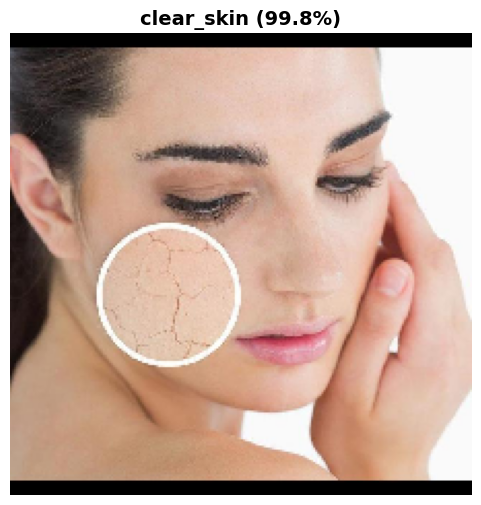

In [14]:
# ============================================
# MODULE 4 – FINAL SKIN CONDITION PREDICTION
# (NO FACE DETECTION – DEBUG & VERIFY MODEL)
# ============================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# ------------------------------------------------
# 1️⃣ LOAD TRAINED MODEL
# ------------------------------------------------
MODEL_PATH = "skin_condition_model_m4_optimized.keras"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✔ Skin model loaded successfully")

CLASS_NAMES = ["clear_skin", "dark_spots", "puffy_eyes", "wrinkles"]

# ------------------------------------------------
# 2️⃣ IMAGE PREDICTION FUNCTION
# ------------------------------------------------
def predict_image(image_path):
    
    if not os.path.exists(image_path):
        print("❌ Image not found:", image_path)
        return
    
    # Load image (EXACT SAME SIZE AS TRAINING)
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    
    # Normalize exactly like training
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    preds = model.predict(img_array)[0]
    
    print("\n🔍 Prediction Probabilities:")
    for name, p in zip(CLASS_NAMES, preds):
        print(f"{name}: {p*100:.2f}%")
    
    idx = np.argmax(preds)
    label = CLASS_NAMES[idx]
    confidence = preds[idx] * 100
    
    print(f"\n✅ FINAL PREDICTION: {label}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")
    
    # Show image
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({confidence:.1f}%)", fontsize=14, fontweight="bold")
    plt.show()

# ------------------------------------------------
# 3️⃣ TEST IMAGE (CHANGE THIS PATH ONLY)
# ------------------------------------------------
TEST_IMAGE = r"DATASET/clear_skin/dry_7d1580f09a0f22cbb869_jpg.rf.e23e6348aba524a6564650d07f1210b5.jpg"

predict_image(TEST_IMAGE)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
DATASET = "DATASET"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 60

CLASS_NAMES = ["clear_skin", "dark_spots", "puffy_eyes", "wrinkles"]


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_data = datagen.flow_from_directory(
    DATASET,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASS_NAMES,
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATASET,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASS_NAMES,
    subset="validation",
    shuffle=False
)


Found 5941 images belonging to 4 classes.
Found 1483 images belonging to 4 classes.


In [4]:
print(train_data.class_indices)


{'clear_skin': 0, 'dark_spots': 1, 'puffy_eyes': 2, 'wrinkles': 3}


In [5]:
base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(4, activation="softmax")(x)

model = Model(base.input, out)

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "model_checkpoint.h5",
    save_best_only=True,
    monitor="val_loss"
)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3349 - loss: 1.6074  

186/186 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.4156 - loss: 1.3800 - val_accuracy: 0.6541 - val_loss: 0.9228
Epoch 2/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5911 - loss: 0.9919  

186/186 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.6154 - loss: 0.9505 - val_accuracy: 0.7330 - val_loss: 0.7288
Epoch 3/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6861 - loss: 0.7973     

186/186 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.6963 - loss: 0.7774 - val_accuracy: 0.7620 - val_loss: 0.6571
Epoch 4/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7157 - loss: 0.7405      

186/186 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.7266 - loss: 0.7115 - val_accuracy: 0.7802 - val_loss: 0.6008
Epoch 5/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.7419 - loss: 0.6776  

186/186 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7489 - loss: 0.6597 - val_accuracy: 0.7950 - val_loss: 0.5488
Epoch 6/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.7623 - loss: 0.6226  

186/186 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7613 - loss: 0.6090 - val_accuracy: 0.8024 - val_loss: 0.5382
Epoch 7/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7721 - loss: 0.5902     

186/186 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7724 - loss: 0.5875 - val_accuracy: 0.8152 - val_loss: 0.5145
Epoch 8/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.7770 - loss: 0.5872  

186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7797 - loss: 0.5735 - val_accuracy: 0.8294 - val_loss: 0.4924
Epoch 9/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.7793 - loss: 0.5687  

186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7913 - loss: 0.5542 - val_accuracy: 0.8301 - val_loss: 0.4676
Epoch 10/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.8086 - loss: 0.5215  

186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8036 - loss: 0.5307 - val_accuracy: 0.8388 - val_loss: 0.4494
Epoch 11/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8008 - loss: 0.5295  

186/186 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8010 - loss: 0.5270 - val_accuracy: 0.8355 - val_loss: 0.4472
Epoch 12/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8063 - loss: 0.5058  

186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8046 - loss: 0.5075 - val_accuracy: 0.8341 - val_loss: 0.4467
Epoch 13/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.8068 - loss: 0.4991 - val_accuracy: 0.8287 - val_loss: 0.4561
Epoch 14/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8191 - loss: 0.4886  

186/186 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8162 - loss: 0.4879 - val_accuracy: 0.8429 - val_loss: 0.4418
Epoch 15/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.8102 - loss: 0.4978  

186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8132 - loss: 0.4836 - val_accuracy: 0.8618 - val_loss: 0.4147
Epoch 16/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.8245 - loss: 0.4632  

186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8214 - loss: 0.4750 - val_accuracy: 0.8402 - val_loss: 0.4099
Epoch 17/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8223 - loss: 0.4622 - val_accuracy: 0.8456 - val_loss: 0.4137
Epoch 18/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.8307 - loss: 0.4517  

186/186 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8275 - loss: 0.4630 - val_accuracy: 0.8476 - val_loss: 0.4098
Epoch 19/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.8124 - loss: 0.4717  

186/186 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.8179 - loss: 0.4631 - val_accuracy: 0.8543 - val_loss: 0.4006
Epoch 20/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.8327 - loss: 0.4613  

186/186 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.8374 - loss: 0.4422 - val_accuracy: 0.8584 - val_loss: 0.3842
Epoch 21/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8337 - loss: 0.4348 - val_accuracy: 0.8496 - val_loss: 0.4177
Epoch 22/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8266 - loss: 0.4518 - val_accuracy: 0.8570 - val_loss: 0.4040
Epoch 23/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8345 - loss: 0.4308 - val_accuracy: 0.8570 - val_loss: 0.3890
Epoch 24/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.8382 - loss: 0.4257  

186/186 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8367 - loss: 0.4239 - val_accuracy: 0.8577 - val_loss: 0.3780
Epoch 25/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.8400 - loss: 0.4161  

186/186 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8381 - loss: 0.4211 - val_accuracy: 0.8712 - val_loss: 0.3679
Epoch 26/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8389 - loss: 0.4233 - val_accuracy: 0.8624 - val_loss: 0.3811
Epoch 27/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 22239s 120s/step - accuracy: 0.8411 - loss: 0.4225 - val_accuracy: 0.8597 - val_loss: 0.3702
Epoch 28/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.8519 - loss: 0.4028 - val_accuracy: 0.8624 - val_loss: 0.3780
Epoch 29/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8478 - loss: 0.4118   

186/186 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.8531 - loss: 0.3968 - val_accuracy: 0.8719 - val_loss: 0.3563
Epoch 30/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 542s 3s/step - accuracy: 0.8488 - loss: 0.4088 - val_accuracy: 0.8705 - val_loss: 0.3587
Epoch 31/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.8455 - loss: 0.4082 - val_accuracy: 0.8678 - val_loss: 0.3589
Epoch 32/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8493 - loss: 0.3974  

186/186 ━━━━━━━━━━━━━━━━━━━━ 1107s 6s/step - accuracy: 0.8462 - loss: 0.4035 - val_accuracy: 0.8692 - val_loss: 0.3504
Epoch 33/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8512 - loss: 0.4012 - val_accuracy: 0.8678 - val_loss: 0.3551
Epoch 34/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.8475 - loss: 0.4026 - val_accuracy: 0.8618 - val_loss: 0.3662
Epoch 35/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8490 - loss: 0.3988  

186/186 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8526 - loss: 0.3922 - val_accuracy: 0.8820 - val_loss: 0.3247
Epoch 36/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8520 - loss: 0.3894 - val_accuracy: 0.8739 - val_loss: 0.3477
Epoch 37/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8532 - loss: 0.3910 - val_accuracy: 0.8753 - val_loss: 0.3332
Epoch 38/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8517 - loss: 0.3921 - val_accuracy: 0.8611 - val_loss: 0.3499
Epoch 39/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8527 - loss: 0.3952 - val_accuracy: 0.8685 - val_loss: 0.3533
Epoch 40/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.8546 - loss: 0.3902 - val_accuracy: 0.8753 - val_loss: 0.3522
Epoch 41/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8559 - loss: 0.3863 - val_accuracy: 0.8813 - val_loss: 0.3350
Epoch 42/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.8561 - loss: 0.3784 - val_accuracy

186/186 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.8615 - loss: 0.3753 - val_accuracy: 0.8867 - val_loss: 0.3177
Epoch 46/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8573 - loss: 0.3793 - val_accuracy: 0.8726 - val_loss: 0.3395
Epoch 47/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.8586 - loss: 0.3737 - val_accuracy: 0.8665 - val_loss: 0.3373
Epoch 48/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.8595 - loss: 0.3705 - val_accuracy: 0.8827 - val_loss: 0.3363
Epoch 49/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8648 - loss: 0.3608 - val_accuracy: 0.8901 - val_loss: 0.3242
Epoch 50/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8616 - loss: 0.3681 - val_accuracy: 0.8813 - val_loss: 0.3383
Epoch 51/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.8615 - loss: 0.3722 - val_accuracy: 0.8712 - val_loss: 0.3300
Epoch 52/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8579 - loss: 0.3717 - val_accuracy

186/186 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8625 - loss: 0.3651 - val_accuracy: 0.8840 - val_loss: 0.3175
Epoch 55/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.8626 - loss: 0.3654 - val_accuracy: 0.8793 - val_loss: 0.3235
Epoch 56/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8611 - loss: 0.3599  

186/186 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.8628 - loss: 0.3589 - val_accuracy: 0.8921 - val_loss: 0.2991
Epoch 57/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.8569 - loss: 0.3762 - val_accuracy: 0.8840 - val_loss: 0.3109
Epoch 58/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.8613 - loss: 0.3664 - val_accuracy: 0.8692 - val_loss: 0.3458
Epoch 59/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8600 - loss: 0.3625  

186/186 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8616 - loss: 0.3592 - val_accuracy: 0.8975 - val_loss: 0.2989
Epoch 60/60
186/186 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8647 - loss: 0.3586 - val_accuracy: 0.8914 - val_loss: 0.3099


In [ ]:
model.save("skin_condition_model.keras")
print("✅ Final model saved")